In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tacoma as tc
import contact_networks as cn
import util

# Module for experiments with code snippets

In [11]:
# Simulation walkthrough for a single location
# Load data as a pandas DataFrame
df_base = pd.read_parquet('./VF_data/rns_data_2.parquet')[['p_id', 'activity_start_min', 'loc_id_end', 'activity_name_mct', 'activity_end_min']]
df_base = df_base.astype({'activity_start_min': 'uint32', 'activity_end_min': 'uint32'})
# Set simualtion time, for this example we simulate over the entire time range from the TAPAS data
t_start, t_end = df_base.activity_start_min.min(), df_base.activity_end_min.max()

# Select a location
# group by location and sort by size (number of visitors during simulated day)
locations = df_base.groupby('loc_id_end').size().sort_values(ascending=False).index.values
# Some example locations
loc1018 = df_base[df_base.loc_id_end == locations[1018]]
loc1003 = df_base[df_base.loc_id_end == locations[1003]]
loc1015 = df_base[df_base.loc_id_end == locations[1015]]
loc2101 = df_base[df_base.loc_id_end == locations[2101]]

# Start simulation
# Build Location
Loc = cn.Location(1015, 10, 10, 10, 10)
# Build simulation class
HN = cn.ContactNetwork(loc1018, Loc, t_start, t_end, n_scale=1)
# (optional) set paraemters of simulation class
HN.tlw_max_wt = 100

HN.make_movement('random')

start


In [3]:
tn = HN.make_tacoma_network(None, None)

get baseline contacts
done
 select contacts
done
import to tacoma


: 

In [15]:
def baseline(df, min_contact_duration=None):
        start_times, end_times = df.activity_start_min.values, df.activity_end_min.values
        event_ids = df.p_id.values
        loc_id_end = df.loc_id_end.values[0]
        # Takes a df containing all activities at location
        # Returns all possible contacts

        # Broadcast the start_time and end_time arrays for comparison with each other
        overlap_start = np.maximum.outer(start_times, start_times)
        overlap_end = np.minimum.outer(end_times, end_times)

        # Calculate the overlap duration matrix 
        overlap_durations = np.maximum(overlap_end - overlap_start, np.zeros(shape=overlap_start.shape)).astype('uint16')
        
        # Set lower triangle and main diagonal to zero (overlap of an event with itself and double counting)
        overlap_durations = np.triu(overlap_durations, 1)

        # Extract contact rows, cols
        rows, cols = np.where(overlap_durations > 0)
        p_A = event_ids[rows].astype('int')

        # Save contacts to new DataFrame
        df_contacts = pd.DataFrame({'p_A': p_A,'p_B': event_ids[cols].astype('int'), 
                        'start_of_contact': overlap_start[rows, cols].astype('int'),
                        'end_of_contact': overlap_end[rows, cols].astype('int'),
                        'loc_id': np.repeat(loc_id_end, len(p_A)).astype('int32')})
        
        # Calculate contact durations
        df_contacts['contact_duration'] = df_contacts.end_of_contact - df_contacts.start_of_contact

        # (optional) drop contacts below specified contact duration
        if min_contact_duration:
            df_contacts = df_contacts[df_contacts.contact_duration >= min_contact_duration]
        
        return df_contacts


p_add, avg_contact_duration, sigma = .001, 10, 3
def random(contact):
        # TODO: implement
        tstart, tend = contact.start_of_contact, contact.end_of_contact

        # Select contacts randomly
        selected_contact = np.full(tend - tstart, False) 
        # Random start times
        start = np.where(np.random.rand(tend - tstart) <= p_add)[0]
        # Random durations
        duration = np.ceil(np.random.normal(avg_contact_duration, sigma, len(start))).astype('int')
        duration[duration <= 0] = 1
        end = start + duration

        # Avoid multi edges
        for s, e in zip(start, end):
            selected_contact[s: e + 1] = True
        
        selected_contact_start, selected_contact_end = util.boolean_blocks_indices(selected_contact)
        selected_contact_start += tstart
        selected_contact_end += tstart

        n = len(selected_contact_start)
        data = {'p_A': np.full(n, contact.p_A), 'p_B': np.full(n, contact.p_B), 'start_of_contact': selected_contact_start, 'end_of_contact': selected_contact_end}
        return pd.DataFrame(data).reset_index(drop=True)

df = loc1018#.head(400)
# print(loc1015.shape)
contacts = baseline(df)
result = contacts.apply(random, axis=1)
selected_contacts = pd.concat(result.to_list(), ignore_index=True)

In [16]:
selected_contacts['contact_duration'] = selected_contacts.end_of_contact - selected_contacts.start_of_contact
selected_contacts.min()

p_A                   0
p_B                   0
start_of_contact    163
end_of_contact      177
contact_duration      1
dtype: int64

In [18]:
unique_nodes = df.p_id.unique()
tn = tc.edge_changes()
tn.N = 2000 #len(unique_nodes)
tmax, tmin = selected_contacts.end_of_contact.max(), selected_contacts.start_of_contact.min()
Nt = tmax - tmin + 1
print(tmax, tmin)
tn.t = list(range(tmin, tmax + 1))
tn.tmax = tmax + 1
tn.time_unit = '60s'

# Make edges
print('start with edges')
edges_in, edges_out = [[] for _ in range(Nt)], [[] for _ in range(Nt)]
for _, c in selected_contacts.iterrows():
    #print(c)
    edges_in[c.start_of_contact - tmin].append([c.p_A, c.p_B])
    edges_out[c.end_of_contact - tmin].append([c.p_A, c.p_B])

tn.edges_in = edges_in
tn.edges_out = edges_out

# Check for errors
print('edge changes errors: ', tc.verify(tn))

1163 163
start with edges
edge changes errors:  0


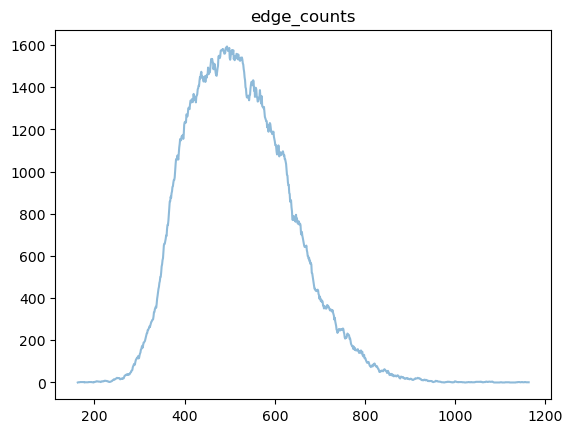

In [19]:
_, _, m = tc.edge_counts(tn)
plt.title('edge_counts')
plt.plot(tn.t, m[:-1], alpha=.5)

(array([0.00000000e+00, 7.13514000e-03, 6.45989016e-03, 9.65607275e-03,
        1.75790042e-02, 3.02737013e-02, 4.62321059e-02, 7.11938417e-02,
        9.31844783e-02, 1.16345548e-01, 1.23863329e-01, 1.27982353e-01,
        1.09818133e-01, 8.74673629e-02, 6.27532187e-02, 4.11002071e-02,
        2.32736112e-02, 1.31448636e-02, 5.80714864e-03, 2.72350770e-03,
        1.30548303e-03, 6.75249842e-04, 6.30233186e-04, 3.37624921e-04,
        3.37624921e-04, 3.15116593e-04, 1.57558297e-04, 1.57558297e-04,
        4.50166562e-05, 4.50166562e-05]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

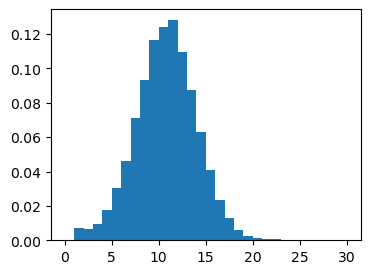

In [32]:
from tacoma.analysis import plot_contact_durations
result = tc.measure_group_sizes_and_durations(tn)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
#plot_contact_durations(result, ax, time_unit='s', use_logarithmic_histogram=True)

plt.hist(result.contact_durations, density=True, bins=range(0, 31))

In [38]:
arr = np.arange(0, 100, 1)
slices = (slice(10, 15, None), slice(27, 31, None))
arr[(Ellipsis, *slices)]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed